In [1]:
import numpy as np
import pandas as pd
import emcee
import corner
import time
import scipy.optimize as op
from allsn_info import get_at2019dge
from helper.arnett import model_arnett_Ltph
from multiprocessing import Pool
from helper import phys
from helper.mcmcfit import mylinear_fit
from helper.models_piro2020 import model_piro20_bol

import matplotlib
import matplotlib.pyplot as plt
fs = 14
matplotlib.rcParams['font.size']=fs

## Method1: Model Fitting

In [2]:
filename = "./helper/piromodel_2020/2.0/sampler.h5"
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain(discard=1000, flat=True)
lgR_sigmas = np.percentile(samples[:,0], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
lgM_sigmas = np.percentile(samples[:,1], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
t0_sigmas = np.percentile(samples[:,2], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
Eenvs_sigmas = np.percentile(samples[:,3], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87)) * 1e+49

Eenv = Eenvs_sigmas[3] 
Renv = 10**lgR_sigmas[3] 
Menv = 10**lgM_sigmas[3] 
t0 =t0_sigmas[3]

In [3]:
data = pd.read_csv('../data/otherSN/Yao2020/bbdata.csv')
t_data = data['phase'].values - t0
L_data = data['Lbb'].values
L_unc_data = data['Lbb_unc'].values
lgL_data = data['lgLbb'].values
lgL_unc_data = data['lgLbb_unc'].values

In [28]:
tgrid = np.linspace(0, 30, 100)
Lp20 = model_piro20_bol(tgrid, Menv, Renv, Eenv / 1e+49)
lgLp20 = np.log10(Lp20)

In [29]:
result = get_at2019dge()
tb0 = result['tb']

In [30]:
tb0 = tb0[tb0['filter'].values=='r']
tb0 = tb0[tb0.instrument!="P60+SEDM"]
tb0 = tb0[(tb0.tmax_of-t0) > max(t_data)]
t_quasi = tb0["tmax_of"].values -t0
Lquasi = tb0["Llambda"].values * tb0['wave'].values
Lquasi_unc = tb0["Llambda_unc"].values * tb0['wave'].values
lgLquasi = np.log10(Lquasi)
lgLquasi_unc = Lquasi_unc / Lquasi / np.log(10)

In [31]:
Lp20_data = model_piro20_bol(t_data, Menv, Renv, Eenv / 1e+49)

In [32]:
L_data_resi = L_data - Lp20_data
lgL_data_resi = np.log10(L_data_resi)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


(-2e+41, 5.2e+42)

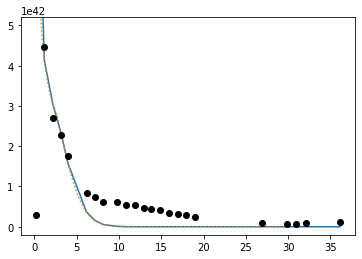

In [35]:
plt.figure()
plt.plot(t_data, Lp20_data)
plt.plot(tgrid, Lp20, ':')
plt.plot(t_data, L_data, 'ko')
plt.ylim(-2e+41, 5.2e+42)

In [36]:
%matplotlib notebook

<IPython.core.display.Javascript object>


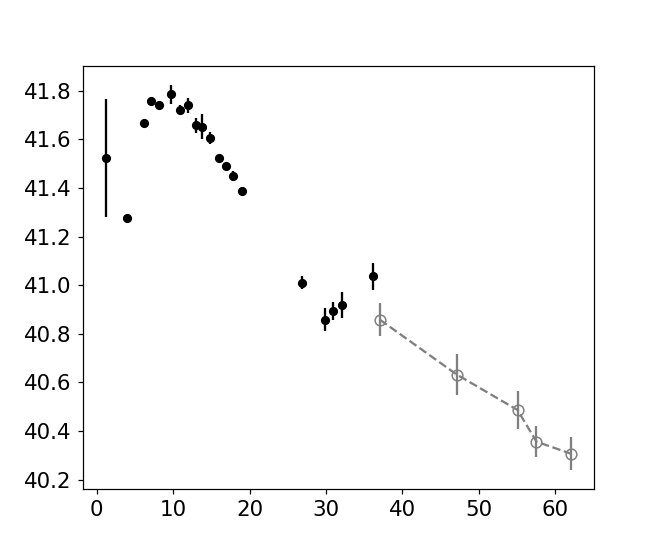

<ErrorbarContainer object of 3 artists>

In [37]:
plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax.errorbar(t_quasi, lgLquasi, lgLquasi_unc, fmt='--o', color = "grey", markerfacecolor='none', zorder = 3, markersize=7)
ax.errorbar(t_data, lgL_data_resi, lgL_unc_data, fmt='ok', zorder = 3, markersize=5)

In [84]:
x1 = t_data
y1 = lgL_data_resi
ey1 = lgL_unc_data
ix1 = (~np.isnan(y1))&(x1 > 2)
x1 = x1[ix1]
y1 = y1[ix1]
ey1 = ey1[ix1]

ix = x1 > 5
x1 = x1[ix]
y1 = y1[ix]
ey1 = ey1[ix]


In [85]:
x3 = t_quasi
y3 = lgLquasi
ey3 = lgLquasi_unc

In [86]:
x = np.hstack([x1, x3]) + t0
y = np.hstack([y1, y3])
ey = np.hstack([ey1, ey3])
ix = np.argsort(x)
x = x[ix]
y = y[ix]
ey = ey[ix]

In [87]:
xyey = np.vstack([x, y, ey])

<IPython.core.display.Javascript object>


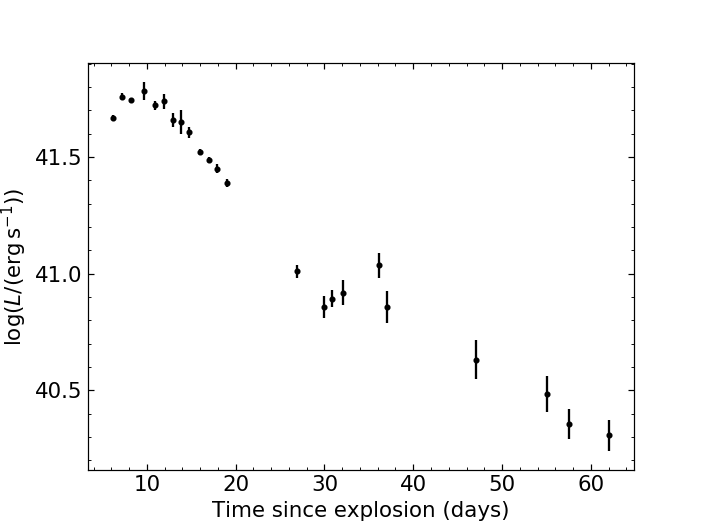

In [88]:
def get_refineLbbaxis(ax):
    ax.set_ylabel(r'${\rm log} ( L/{\rm(erg\,s^{-1} } ))$')
    ax.set_xlabel('Time since explosion (days)')
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax.tick_params(direction='in', axis='both', which = 'both', top=True, right=True)
    ax.tick_params(which = 'major', length = 4)
    ax.tick_params(which = 'minor', length = 2)
plt.figure()
ax = plt.subplot(111)
ax.errorbar(x-t0, y, ey, fmt=".k")
get_refineLbbaxis(ax)

In [91]:
t0

-2.9112151494264173

In [90]:
np.savetxt("./helper/Lbb_p20subtracted.txt", xyey)

### Photospheric phase Arnett model -- modified

In [83]:
# main_arnettrun()
# This takes some time to run

In [92]:
filename = "./helper/arnettmodel/sampler.h5"
reader = emcee.backends.HDFBackend(filename)

In [93]:
samples = reader.get_chain(discard=200, flat=True)
lgprobs = reader.get_log_prob(discard=200, flat=True)
print (samples.shape)
print (lgprobs.shape)

(600000, 4)
(600000,)


In [94]:
taum_sigmas = np.percentile(samples[:,0], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
lgMni_sigmas = np.percentile(samples[:,1], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
t0_sigmas = np.percentile(samples[:,2], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
tfl_sigmas = np.percentile(samples[:,3], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
texp = tfl_sigmas[3]

In [95]:
paramsNames= [r"$\tau_{\rm m}$", 
                 'log' +r'$M_{\rm Ni}$', 
                 r"$t_0$",
             r"$t_{\rm fl}$"]
quantiles=[0.1587, 0.5, 0.8413]

In [96]:
samples_final = samples[:, :3]

<IPython.core.display.Javascript object>


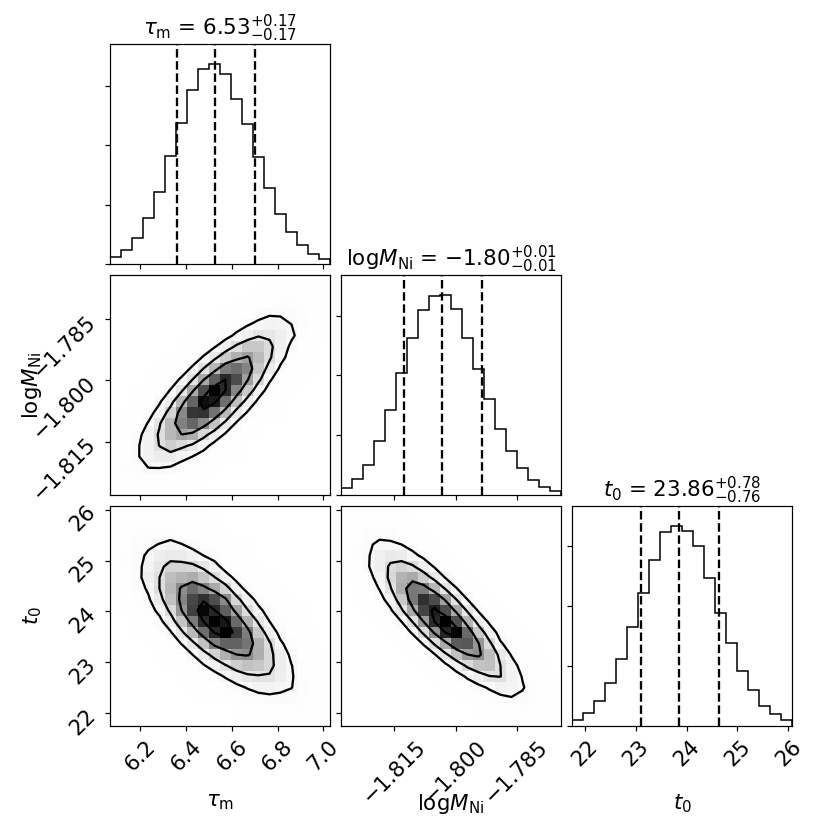

In [98]:
corner.corner(samples_final, labels = paramsNames[:3], quantiles = quantiles, 
              range = [0.995, 0.995, 0.995],
              show_titles=True, plot_datapoints=False, 
               title_kwargs = {"fontsize": fs})
plt.savefig("../paper/figures/corner_arnett_modified_all.pdf")
# plt.close()

In [99]:
taum_ = taum_sigmas[3]
taum_unc_right = taum_sigmas[4]-taum_sigmas[3]
taum_unc_left = taum_sigmas[3]-taum_sigmas[2]
print ("tau_m = %.2f + %.2f - %.2f day"%(taum_, taum_unc_right, taum_unc_left))

tau_m = 6.53 + 0.18 - 0.17 day


In [100]:
Mni = 10**lgMni_sigmas[3] 
Mni_unc_left = 10**lgMni_sigmas[3] - 10**lgMni_sigmas[2] 
Mni_unc_right = 10**lgMni_sigmas[4] - 10**lgMni_sigmas[3] 
print ("%.2f (+%.2f) (-%.2f) 1e-2 Msun"%(Mni*100, Mni_unc_right*100, Mni_unc_left*100))

1.57 (+0.04) (-0.03) 1e-2 Msun


In [101]:
t0_ = t0_sigmas[3]
t0_unc_right = t0_sigmas[4]-t0_sigmas[3]
t0_unc_left = t0_sigmas[3]-t0_sigmas[2]
print ("t0 = %.2f + %.2f - %.2f day"%(t0_, t0_unc_right, t0_unc_left))

t0 = 23.86 + 0.78 - 0.76 day


In [102]:
from helper.arnett import model_arnett_modified
tgrid = np.linspace(0.1, 70, 200)
Lnidecay = model_arnett_modified(tgrid, taum_ = taum_, Mni_ = Mni, t0_ = t0_, texp = 0)
lgLnidecay = np.log10(Lnidecay)

<IPython.core.display.Javascript object>


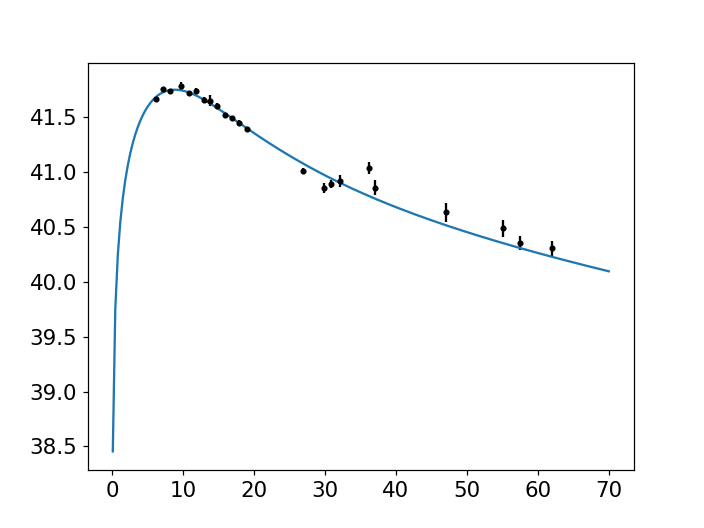

In [103]:
plt.figure()
plt.errorbar(x-texp, y, ey, fmt= ".k")
plt.plot(tgrid, lgLnidecay)

Estimate ejecta mass

In [104]:
kappa_opt = 0.07 # relevant for stripped envelope supernova
v_ej = 8000 * 1e+5
Mej_ = (taum_ * 24 * 3600)**2 * 13.8 * phys.c / 2 / kappa_opt * v_ej / phys.sm
Mej_unc_right = ((taum_+taum_unc_right) * 24 * 3600)**2 * 13.8 * phys.c / 2 / kappa_opt * v_ej / phys.sm - Mej_
Mej_unc_left = Mej_ - ((taum_-taum_unc_left) * 24 * 3600)**2 * 13.8 * phys.c / 2 / kappa_opt * v_ej / phys.sm 
print ("Mej = %.2f (+%.2f) (-%.2f) Msun"%(Mej_, Mej_unc_right, Mej_unc_left))

Mej = 0.38 (+0.02) (-0.02) Msun


In [105]:
Ekin_ = 0.3 * Mej_ * phys.sm * v_ej**2
Ekin_unc_left = 0.3 * Mej_unc_left * phys.sm * v_ej**2
Ekin_unc_right = 0.3 * Mej_unc_right * phys.sm * v_ej**2
print ("Ekin = %.2f (+%.2f) (-%.2f) e+50 erg"%(Ekin_ / 1e+50, Ekin_unc_right / 1e+50, Ekin_unc_left / 1e+50))

Ekin = 1.44 (+0.08) (-0.07) e+50 erg


In [106]:
ind_max = np.argsort(Lnidecay)[-1]

In [107]:
tpeak = (tgrid[ind_max]) * 86400
Lpeak = Lnidecay[ind_max]

In [108]:
print ("tpeak = %.1f day"%(tpeak / 86400))
print ("Lpeak = %.1f e+41 erg/s"%(Lpeak / 1e+41))

tpeak = 8.9 day
Lpeak = 5.6 e+41 erg/s


## Method2: KK19 Equations
An improvement from the Arnett relations.

In [109]:
ts = 8.8*86400
beta = 4/3
L0 = Lpeak * beta**2 * tpeak**2 / 2 / ts**2 / (1 - (1 + beta*tpeak/ts)*np.exp(-beta * tpeak / ts))
epsilon_Ni = 3.9e+10 # erg / g / s
M_Ni = L0 / (epsilon_Ni) / phys.sm

In [110]:
print ("M_Ni = %.2f e-2 Msun"%(M_Ni/1e-2))

M_Ni = 1.69 e-2 Msun


\begin{align}
x &= \frac{t_{\rm peak}}{t_{\rm d}}\\
x &= 0.11 {\rm ln} (1 + 9 \frac{8.8}{9}x) + 0.36
\end{align}

In [111]:
x = np.linspace(0.1, 1, 100)
y = 0.11 * np.log(1 + 8.8*x) + 0.36

<IPython.core.display.Javascript object>


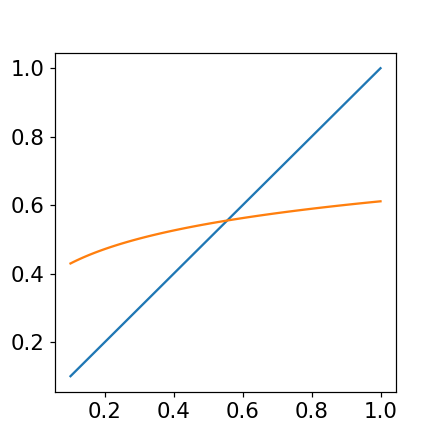

In [112]:
plt.figure(figsize=(4,4))
plt.plot(x, x)
plt.plot(x, y)

In [114]:
ix = np.argsort(abs(y-x))

x_solved = x[ix[0]]

In [115]:
td = tpeak / x_solved

In [116]:
td / 86400

16.015652030645025

In [117]:
kappa = 0.07 # DD19 default
vej = 8000 * 1e+5
Mej_kk = td**2 * vej * phys.c / kappa / phys.sm
print (Mej_kk)

0.32992039056645617


In [118]:
0.3 * Mej_kk * phys.sm * vej**2

1.2595940844675004e+50